# Multivariate Unconstrained Optimization

In many civil engineering problems, we are tasked with finding the best possible solution from a set of feasible options. This often translates to minimizing or maximizing a certain objective function. When this function depends on multiple variables and there are no constraints on these variables, we are dealing with an **unconstrained multivariate optimization problem**.

For instance, we might want to:

  * Minimize the cost of a structure by varying its dimensions.
  * Maximize the hydraulic efficiency of a channel by adjusting its cross-sectional shape.
  * Calibrate a complex hydrological model by finding the set of parameters that minimizes the error between simulated and observed data.

Mathematically, we can express this as:

$$\min_{\boldsymbol{x} \in \mathbb{R}^n} f(\boldsymbol{x})$$

where $\boldsymbol{x}$ is a vector of $n$ variables, i.e., $\boldsymbol{x} = [x_1, x_2, \ldots, x_n]^T$, and $f:\mathbb{R}^n \to \mathbb{R}$ is the scalar objective function we want to minimize.

In this notebook, we will explore three powerful iterative methods for solving such problems:

1.  Gradient descent
2.  Newton's method
3.  Levenberg-Marquardt algorithm

We will implement these methods in Python and test them on two standard benchmark functions: the Rosenbrock function and Himmelblau's function. We will also incorporate practical termination criteria to ensure our algorithms stop efficiently.

### **Initial Setup**

Let's start by importing the necessary Python libraries. We'll need `numpy` for numerical operations and `time` to track computation time.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import check_grad, approx_fprime

#%matplotlib widget
#conda install -c conda-forge ipympl ipywidgets

-----

## 1. Test Functions for Optimization

To evaluate our optimization algorithms, we will use two well-known and challenging test functions.

### 1.1. Rosenbrock Function

The Rosenbrock function is a non-convex function often used to test the performance of optimization algorithms. Its global minimum is located inside a long, narrow, parabolic-shaped flat valley.

The function is defined as:

$$f(x, y) = (1 - x)^2 + 100(y - x^2)^2$$

The global minimum is at $\boldsymbol{x} = [1, 1]^T$, where $f(1, 1) = 0$.

The gradient is:

$$
\nabla f(x, y) = \begin{bmatrix}
-2(1-x) - 400x(y-x^2) \\
200(y-x^2)
\end{bmatrix}
$$

The Hessian matrix is:

$$
\boldsymbol{H}_f(x, y) =
\begin{bmatrix}
2 - 400y + 1200x^2 & -400x \\
-400x & 200
\end{bmatrix}
$$

In [2]:
def rosenbrock(vars):
    """Rosenbrock function."""
    x, y = vars
    return (1 - x)**2 + 100*(y - x**2)**2

def rosenbrock_grad(vars):
    """Gradient of the Rosenbrock function."""
    x, y = vars
    return np.array([
      -2*(1 - x) - 400*x*(y - x**2),
      200*(y - x**2)
    ])

def rosenbrock_hess(vars):
    """Hessian of the Rosenbrock function."""
    x, y = vars
    return np.array([
      [2 - 400*y + 1200*x**2, -400*x],
      [               -400*x,    200]
    ])

rosenbrock_range   = np.array([[-2.0, 2.0], [-5.0, 3.0]])
rosenbrock_minimum = np.array([[1.0, 1.0]])

### 1.2. Himmelblau's Function

Himmelblau's function is another standard test function, notable for having four distinct global minima.

The function is defined as:

$$f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$

The four global minima are:
\begin{align*}
\boldsymbol{x}_1 &= [3, 2]^T                 & f(\boldsymbol{x}_1) &= 0 \\
\boldsymbol{x}_2 &= [-2.805118, 3.131312]^T  & f(\boldsymbol{x}_2) &= 0 \\
\boldsymbol{x}_3 &= [-3.779310, -3.283186]^T & f(\boldsymbol{x}_3) &= 0 \\
\boldsymbol{x}_4 &= [3.584428, -1.848126]^T  & f(\boldsymbol{x}_4) &= 0
\end{align*}

The gradient is:

$$
\nabla f(x, y) =
\begin{bmatrix}
2(x^2+y-11)(2x) + 2(x+y^2-7) \\
2(x^2+y-11) + 2(x+y^2-7)(2y)
\end{bmatrix}
$$

The Hessian matrix is:

$$
\boldsymbol{H}_f(x, y) =
\begin{bmatrix}
12x^2 + 4y - 42 & 4x + 4y \\
4x + 4y         & 4x + 12y^2 - 26
\end{bmatrix}
$$

In [3]:
def himmelblau(vars):
    """Himmelblau's function."""
    x, y = vars
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def himmelblau_grad(vars):
    """Gradient of Himmelblau's function."""
    x, y = vars
    return np.array([
        4*x*(x**2 + y - 11) + 2*(x + y**2 - 7),
        2*(x**2 + y - 11) + 4*y*(x + y**2 - 7)
    ])

def himmelblau_hess(vars):
    """Hessian of Himmelblau's function."""
    x, y = vars
    return np.array([
        [12*x**2 + 4*y - 42,          4*x + 4*y],
        [         4*x + 4*y, 4*x + 12*y**2 - 26]
    ])

himmelblau_range   = np.array([[-5.0, 5.0], [-5.0, 5.0]])
himmelblau_minimum = np.array([[ 3.0     ,  2.0     ],
                               [-2.805118,  3.131312],
                               [-3.779310, -3.283186],
                               [ 3.584428, -1.848126]])

### 1.3 Let's verify the gradient and the Hessian

`scipy.optimize` provides the functions `check_grad` and `approx_fprime` that can be used to check the gradients. 

We'll choose an arbitrary point to perform the check. The derivatives should be correct for any point.

In [4]:
point_to_check = np.array([1.5, 2.5])

#### Verify the gradient
The `check_grad` function computes the difference between the analytical gradient (from `rosenbrock_grad`) and a numerical approximation. A very small result (close to zero) indicates the provided gradient function is likely correct.

In [5]:
# Get the gradient from the numerical approximation function
numerical_grad = approx_fprime(point_to_check, rosenbrock)

# Get the gradient from the analytical function
analytical_grad = rosenbrock_grad(point_to_check)

print("Numerical gradient (approximated by SciPy):")
print(numerical_grad)
print("\nAnalytical gradient (from `rosenbrock_grad`):")
print(analytical_grad)

# Calculate the difference between the two vectors
# A small difference indicates the provided gradient function is likely correct.
grad_error = np.linalg.norm(numerical_grad - analytical_grad)
print(f"\nDifference (norm) between numerical and analytical gradient: {grad_error}")

grad_error = check_grad(rosenbrock, rosenbrock_grad, point_to_check)
print(f"\nError reported by scipy.optimize.check_grad: {grad_error}\n")
if np.isclose(grad_error, 0, atol=1e-4):
    print("The rosenbrock_grad function appears to be CORRECT.")
else:
    print("The rosenbrock_grad function appears to be INCORRECT.")

Numerical gradient (approximated by SciPy):
[-148.99998808   50.00000149]

Analytical gradient (from `rosenbrock_grad`):
[-149.   50.]

Difference (norm) between numerical and analytical gradient: 1.2013700229374393e-05

Error reported by scipy.optimize.check_grad: 1.2013700229374393e-05

The rosenbrock_grad function appears to be CORRECT.


#### Verify the Hessian
There is no direct `check_hess` function. However, the Hessian is the Jacobian of the gradient. We can use `approx_fprime` (which numerically approximates the forward derivative) to compute the Jacobian of our `rosenbrock_grad` function. This gives us a numerical Hessian.

In [6]:
# We define a lambda function to pass our gradient function to approx_fprime
numerical_hessian = approx_fprime(point_to_check, lambda v: rosenbrock_grad(v))

# Get the Hessian from the analytical function
analytical_hessian = rosenbrock_hess(point_to_check)

print("Numerical Hessian (approximated by SciPy):")
print(numerical_hessian)
print("\nAnalytical Hessian (from `rosenbrock_hess`):")
print(analytical_hessian)

# Calculate the difference between the two matrices using the Frobenius norm.
# A small difference indicates the provided Hessian function is likely correct.
hessian_error = np.linalg.norm(numerical_hessian - analytical_hessian)
print(f"\nDifference (norm) between numerical and analytical Hessian: {hessian_error}\n")

if np.isclose(hessian_error, 0, atol=1e-4):
    print("The rosenbrock_hess function appears to be CORRECT.")
else:
    print("The rosenbrock_hess function appears to be INCORRECT.")

Numerical Hessian (approximated by SciPy):
[[1702.00003624 -600.        ]
 [-600.00000572  200.        ]]

Analytical Hessian (from `rosenbrock_hess`):
[[1702. -600.]
 [-600.  200.]]

Difference (norm) between numerical and analytical Hessian: 3.668858349165219e-05

The rosenbrock_hess function appears to be CORRECT.


-----

## 2. Termination Criteria

For any iterative optimization algorithm, we need to define conditions under which the algorithm should stop. A robust implementation will consider multiple criteria.

1.  **Objective Function Value is Sufficiently Small:**
    If the goal is to minimize the function to a value near zero (as in our test cases), we can stop when $f(\boldsymbol{x}_k) \< \epsilon_f$, where $\epsilon_f$ is a small tolerance.

2.  **Gradient Norm is Sufficiently Small:**
    At a minimum, the gradient of the function is the zero vector. We can therefore stop when the magnitude (norm) of the gradient is close to zero: $\Vert\nabla f(\boldsymbol{x}_k)\Vert < \\epsilon_g$. This is a very common and reliable criterion.

3.  **Computation Time Exceeded:**
    In real-world engineering problems, we often have a limited computational budget. We should stop if the elapsed time exceeds a predefined `max_time`.

-----

## 3. Gradient Descent with Line Search

### 3.1. Theory

The Gradient Descent method is a first-order optimization algorithm. The core idea is to iteratively move in the direction opposite to the gradient of the function at the current point. This is the direction of the steepest descent.

The update rule is:

$$\boldsymbol{x}_{k+1} = \boldsymbol{x}_k - \alpha_k \nabla f(\boldsymbol{x}_k)$$

where:

  * $\boldsymbol{x}_k$ is the current position.
  * $\nabla f(\boldsymbol{x}_k)$ is the gradient of the function at $\boldsymbol{x}_k$.
  * $\alpha_k$ is the step size or learning rate at iteration $k$.

A fixed, small $\alpha$ can work but is often inefficient. A better approach is to use a **line search** to find an optimal $\alpha_k$ at each step. A common line search method is **backtracking**, where we start with a larger $\alpha$ and reduce it until a sufficient decrease in the function value is achieved (satisfying the Armijo condition).

The Armijo condition is a key part of backtracking line search in optimization algorithms. It ensures that the step size taken at each iteration provides a sufficient decrease in the objective function value.

Mathematically, the Armijo condition states that for a given step size $\alpha_k > 0$, the following inequality must hold:
$$
f\big(\boldsymbol{x}_k - \alpha_k \nabla f(\boldsymbol{x}_k)\big) \le f(\boldsymbol{x}_k) - c \alpha_k \Vert \nabla f(\boldsymbol{x}_k) \Vert^2
$$
where $c$ is a small constant between 0 and 1 (typically $c \in (0, 1)$).

The term $-c \alpha_k \Vert \nabla f(\boldsymbol{x}_k) \Vert^2$ represents a minimum required decrease in the function value. The condition essentially says that the function value at the new point $\boldsymbol{x}_k - \alpha_k \nabla f(\boldsymbol{x}_k)$ must be less than or equal to the current function value minus a value proportional to the step size and the squared gradient norm. This prevents taking steps that are too small and don't lead to significant progress towards the minimum.


### 3.2. Python Implementation

In [7]:
def gradient_descent_ls(func, grad_func, x0, tol_f, tol_g, max_time):
    """
    Gradient Descent with backtracking line search.

    Args:
        func:      The objective function.
        grad_func: The gradient of the objective function.
        x0:        The initial point.
        tol_f:     Tolerance for the function value.
        tol_g:     Tolerance for the gradient norm.
        max_time:  Maximum computation time in seconds.

    Returns:
        A dictionary with the results.
    """
    x_k = np.copy(x0)
    start_time = time.perf_counter()
    iterations = 0
    history = [x_k]

    # Line search parameters
    alpha = 1.0
    beta  = 0.5  # Step size reduction factor
    c     = 0.1  # Armijo condition constant

    while True:
        elapsed_time = time.perf_counter() - start_time
        if elapsed_time > max_time:
            print("Termination: Maximum time exceeded.")
            break

        f_k = func(x_k)
        g_k = grad_func(x_k)
        grad_norm = np.linalg.norm(g_k)

        if f_k < tol_f:
            print("Termination: Function value is sufficiently small.")
            break

        if grad_norm < tol_g:
            print("Termination: Gradient norm is sufficiently small.")
            break

        # Backtracking line search (Armijo condition)
        alpha_k = alpha
        while func(x_k - alpha_k*g_k) > f_k - c*alpha_k*grad_norm**2:
            alpha_k *= beta

        x_k = x_k - alpha_k*g_k
        history.append(x_k)
        iterations += 1

    return {
        'minimum':    x_k,
        'f_value':    func(x_k),
        'grad_norm':  np.linalg.norm(grad_func(x_k)),
        'iterations': iterations,
        'time':       time.perf_counter() - start_time,
        'history':    np.array(history)
    }

-----

## 4. Newton's Method

### 4.1. Theory

Newton's method is a second-order optimization algorithm. It uses the second derivatives (the Hessian matrix) to form a quadratic approximation of the objective function around the current point. It then finds the minimum of this quadratic approximation to determine the next step.

The update rule is:

$$
\boldsymbol{x}_{k+1} = \boldsymbol{x}_k - \boldsymbol{H}_f(\boldsymbol{x}_k)^{-1} \nabla f(\boldsymbol{x}_k)
$$

where:

  * $\boldsymbol{H}_f(\boldsymbol{x}_k)$ is the Hessian matrix of the function at $\boldsymbol{x}_k$.
  * $\boldsymbol{H}_f(\boldsymbol{x}_k)^{-1}$ is its inverse.

Newton's method typically converges much faster than gradient descent when close to the minimum. However, it has drawbacks:

  * It requires computing and inverting the Hessian matrix, which can be computationally expensive.
  * It can be unstable if the Hessian is not positive definite.

### 4.2. Python Implementation

In [8]:
def newtons_method(func, grad_func, hess_func, x0, tol_f, tol_g, max_time):
    """
    Newton's method for optimization.

    Args:
        func:      The objective function.
        grad_func: The gradient of the objective function.
        hess_func: The Hessian of the objective function.
        x0:        The initial point.
        tol_f:     Tolerance for the function value.
        tol_g:     Tolerance for the gradient norm.
        max_time:  Maximum computation time in seconds.

    Returns:
        A dictionary with the results.
    """
    x_k = np.copy(x0)
    start_time = time.perf_counter()
    iterations = 0
    history = [x_k]

    while True:
        elapsed_time = time.perf_counter() - start_time
        if elapsed_time > max_time:
            print("Termination: Maximum time exceeded.")
            break

        f_k = func(x_k)
        g_k = grad_func(x_k)
        H_k = hess_func(x_k)
        grad_norm = np.linalg.norm(g_k)

        # Check if the Hessian is positive definite
        if not np.all(np.linalg.eigvals(H_k) > 0):
            print("Termination: Hessian is not positive definite.")
            break

        if f_k < tol_f:
            print("Termination: Function value is sufficiently small.")
            break

        if grad_norm < tol_g:
            print("Termination: Gradient norm is sufficiently small.")
            break

        # Solve the linear system H_k*delta_x_k = -g_k for the search direction
        # delta_x_k. This is more numerically stable than computing the inverse
        # directly.
        try:
            delta_x_k = np.linalg.solve(H_k, -g_k)
        except np.linalg.LinAlgError:
            print("Hessian is singular. Newton's method failed.")
            return None

        x_k = x_k + delta_x_k
        history.append(x_k)
        iterations += 1

    return {
        'minimum':    x_k,
        'f_value':    func(x_k),
        'grad_norm':  np.linalg.norm(grad_func(x_k)),
        'iterations': iterations,
        'time':       time.perf_counter() - start_time,
        'history':    np.array(history)
    }

-----

## 5. Levenberg-Marquardt Algorithm

### 5.1. Theory

The Levenberg-Marquardt algorithm (LMA) provides a bridge between Gradient Descent and Newton's method. It is particularly useful for minimizing non-linear least squares problems but can be adapted for general optimization.

LMA adaptively modifies the search direction. When far from the minimum, it acts like Gradient Descent (slower but more robust). When close to the minimum, it behaves like Newton's method (faster convergence).

The update rule is:

$$
\boldsymbol{x}_{k+1} = \boldsymbol{x}_k - \left[\boldsymbol{H}f(\boldsymbol{x}_k) + \lambda \boldsymbol{I}\right]^{-1} \nabla f(\boldsymbol{x}_k)
$$

where:
  * $\lambda$ is a damping parameter.
  * $\boldsymbol{I}$ is the identity matrix.

Behaviour of $\lambda$:
  * If $\lambda$ is large, the term $\lambda \boldsymbol{I}$ dominates the Hessian, and the update is approximately in the direction of steepest descent: $\boldsymbol{x}_{k+1} \approx \boldsymbol{x}_k - \frac{1}{\lambda} \nabla f(\boldsymbol{x}_k)$.
  * If $\lambda$ is small, the update is close to the Newton step.

The damping parameter $\lambda$ is adjusted at each iteration based on the success of the previous step.

### 5.2. Python Implementation

In [9]:
def levenberg_marquardt(func, grad_func, hess_func, x0, tol_f, tol_g, max_time):
    """
    Levenberg-Marquardt algorithm for optimization.

    Args:
        func:      The objective function.
        grad_func: The gradient of the objective function.
        hess_func: The Hessian of the objective function.
        x0:        The initial point.
        tol_f:     Tolerance for the function value.
        tol_g:     Tolerance for the gradient norm.
        max_time:  Maximum computation time in seconds.

    Returns:
        A dictionary with the results.
    """
    x_k = np.copy(x0)
    start_time = time.perf_counter()
    iterations = 0
    history = [x_k]

    # LMA parameter
    lambda_k = 0.001
    v = 2 # factor to increase/decrease lambda

    while True:
        elapsed_time = time.perf_counter() - start_time
        if elapsed_time > max_time:
            print("Termination: Maximum time exceeded.")
            break

        f_k = func(x_k)
        g_k = grad_func(x_k)
        H_k = hess_func(x_k)
        grad_norm = np.linalg.norm(g_k)

        if f_k < tol_f:
            print("Termination: Function value is sufficiently small.")
            break

        if grad_norm < tol_g:
            print("Termination: Gradient norm is sufficiently small.")
            break

        while True:
            try:
                # Add damping to the Hessian
                A = H_k + lambda_k * np.identity(len(x_k))
                delta_x_k = np.linalg.solve(A, -g_k)
                x_new = x_k + delta_x_k

                # If the step improves the solution, accept it and decrease lambda
                if func(x_new) < f_k:
                    x_k = x_new
                    lambda_k /= v
                    break
                # Otherwise, reject the step and increase lambda
                else:
                    lambda_k *= v
            except np.linalg.LinAlgError:
                # If the solve fails, increase lambda and try again
                lambda_k *= v

        history.append(x_k)
        iterations += 1

    return {
        'minimum':    x_k,
        'f_value':    func(x_k),
        'grad_norm':  np.linalg.norm(grad_func(x_k)),
        'iterations': iterations,
        'time':       time.perf_counter() - start_time,
        'history':    np.array(history)
    }

## 6. Visualization of Optimization Paths

Visualizing the path taken by each algorithm can provide great insight into its behavior. Let's plot the optimization history for the Rosenbrock function.

In [10]:
def plot_optimization_path(func, range, minimum, history, title):
    # Create a grid for the contour plot
    x = np.linspace(range[0][0], range[0][1], 400)
    y = np.linspace(range[1][0], range[1][1], 400)
    X, Y = np.meshgrid(x, y)
    Z = func([X, Y])

    plt.figure(figsize=(10, 8))
    # Use a logarithmic scale for the contours to see the valley better
    plt.contour(X, Y, Z, levels=np.logspace(0, 3.5, 20), cmap='viridis')

    # Plot the path
    path = history
    plt.plot(path[ :, 0], path[ :, 1], 'r-o', markersize=4,  label='Optimization Path', linewidth=1)
    plt.plot(path[ 0, 0], path [0, 1], 'bo',  markersize=8,  label='Start')
    plt.plot(path[-1, 0], path[-1, 1], 'g*',  markersize=12, label='End')
    plt.plot(minimum[:,0], minimum[:,1], 'mP', markersize=10, label='Global Minimum') # Mark the true minimum
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.colorbar(label='f(x, y)')
    plt.show()

-----

## 7. Application and Comparison

Now, let's apply these three algorithms to our test functions.

### 7.1. Rosenbrock Function Showcase

Let's set a common starting point and termination criteria. The Rosenbrock function is tricky, so we'll start at `[-1.5, 1.5]`.

In [11]:
# Common parameters
x0_rosenbrock = np.array([-1.5, 1.5])
tol_f = 1e-8
tol_g = 1e-6
max_time_s = 5

print("--- Optimizing Rosenbrock Function ---")

# Gradient Descent
print("\n1. Gradient Descent with Line Search")
gd_results_rosen = gradient_descent_ls(rosenbrock, rosenbrock_grad, x0_rosenbrock, tol_f, tol_g, max_time_s)
print(f"   Found Minimum:  {gd_results_rosen['minimum']}")
print(f"   Function Value: {gd_results_rosen['f_value']:.2e}")
print(f"   Gradient Norm:  {gd_results_rosen['grad_norm']:.2e}")
print(f"   Iterations:     {gd_results_rosen['iterations']}")
print(f"   Elapsed Time:   {gd_results_rosen['time']:.4f} s")


# Newton's Method
print("\n2. Newton's Method")
nm_results_rosen = newtons_method(rosenbrock, rosenbrock_grad, rosenbrock_hess, x0_rosenbrock, tol_f, tol_g, max_time_s)
if nm_results_rosen:
    print(f"   Found Minimum:  {nm_results_rosen['minimum']}")
    print(f"   Function Value: {nm_results_rosen['f_value']:.2e}")
    print(f"   Gradient Norm:  {nm_results_rosen['grad_norm']:.2e}")
    print(f"   Iterations:     {nm_results_rosen['iterations']}")
    print(f"   Elapsed Time:   {nm_results_rosen['time']:.4f} s")

# Levenberg-Marquardt
print("\n3. Levenberg-Marquardt")
lm_results_rosen = levenberg_marquardt(rosenbrock, rosenbrock_grad, rosenbrock_hess, x0_rosenbrock, tol_f, tol_g, max_time_s)
if lm_results_rosen:
    print(f"   Found Minimum:  {lm_results_rosen['minimum']}")
    print(f"   Function Value: {lm_results_rosen['f_value']:.2e}")
    print(f"   Gradient Norm:  {lm_results_rosen['grad_norm']:.2e}")
    print(f"   Iterations:     {lm_results_rosen['iterations']}")
    print(f"   Elapsed Time:   {lm_results_rosen['time']:.4f} s")

--- Optimizing Rosenbrock Function ---

1. Gradient Descent with Line Search
Termination: Function value is sufficiently small.
   Found Minimum:  [1.00009965 1.00020009]
   Function Value: 9.99e-09
   Gradient Norm:  1.93e-04
   Iterations:     6760
   Elapsed Time:   0.3196 s

2. Newton's Method
Termination: Function value is sufficiently small.
   Found Minimum:  [0.99999973 0.99999946]
   Function Value: 7.20e-14
   Gradient Norm:  5.37e-07
   Iterations:     5
   Elapsed Time:   0.0007 s

3. Levenberg-Marquardt
Termination: Function value is sufficiently small.
   Found Minimum:  [0.99997223 0.9999441 ]
   Function Value: 7.84e-10
   Gradient Norm:  1.16e-04
   Iterations:     21
   Elapsed Time:   0.0015 s


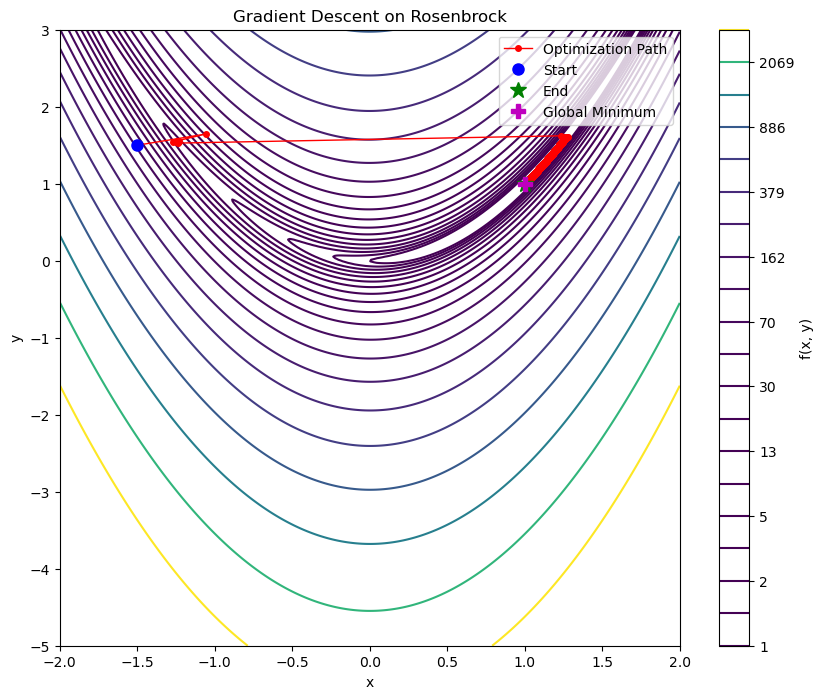

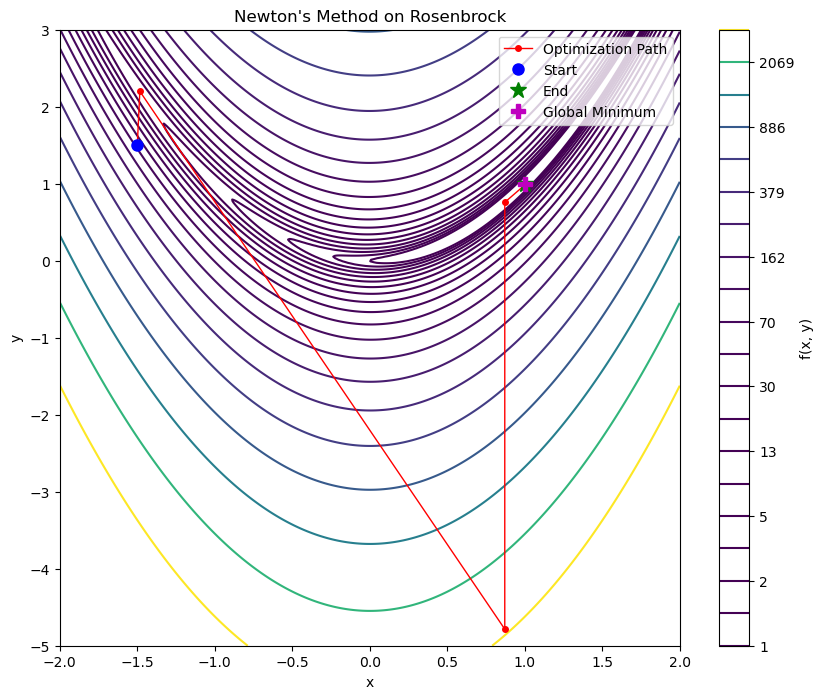

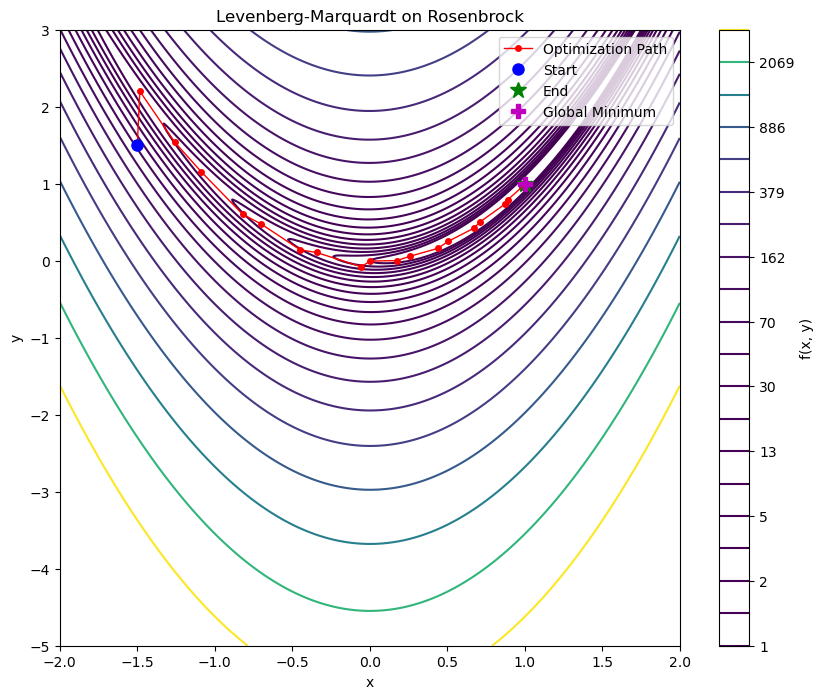

In [12]:
# Plotting for Rosenbrock
plot_optimization_path(rosenbrock, rosenbrock_range, rosenbrock_minimum, gd_results_rosen['history'], "Gradient Descent on Rosenbrock")
plot_optimization_path(rosenbrock, rosenbrock_range, rosenbrock_minimum, nm_results_rosen['history'], "Newton's Method on Rosenbrock")
plot_optimization_path(rosenbrock, rosenbrock_range, rosenbrock_minimum, lm_results_rosen['history'], "Levenberg-Marquardt on Rosenbrock")

### 7.2. Himmelblau's Function Showcase

Let's use the starting point `[0, 0]`.

In [13]:
# Common parameters
x0_himmelblau = np.array([0.0, 0.0])

print("\n--- Optimizing Himmelblau's Function ---")

# Gradient Descent
print("\n1. Gradient Descent with Line Search")
gd_results_himm = gradient_descent_ls(himmelblau, himmelblau_grad, x0_himmelblau, tol_f, tol_g, max_time_s)
print(f"   Found Minimum:  {gd_results_himm['minimum']}")
print(f"   Function Value: {gd_results_himm['f_value']:.2e}")
print(f"   Gradient Norm:  {gd_results_himm['grad_norm']:.2e}")
print(f"   Iterations:     {gd_results_himm['iterations']}")
print(f"   Elapsed Time:   {gd_results_himm['time']:.4f} s")


# Newton's Method
print("\n2. Newton's Method")
nm_results_himm = newtons_method(himmelblau, himmelblau_grad, himmelblau_hess, x0_himmelblau, tol_f, tol_g, max_time_s)
if nm_results_himm:
    print(f"   Found Minimum:  {nm_results_himm['minimum']}")
    print(f"   Function Value: {nm_results_himm['f_value']:.2e}")
    print(f"   Gradient Norm:  {nm_results_himm['grad_norm']:.2e}")
    print(f"   Iterations:     {nm_results_himm['iterations']}")
    print(f"   Elapsed Time:   {nm_results_himm['time']:.4f} s")

# Levenberg-Marquardt
print("\n3. Levenberg-Marquardt")
lm_results_himm = levenberg_marquardt(himmelblau, himmelblau_grad, himmelblau_hess, x0_himmelblau, tol_f, tol_g, max_time_s)
if lm_results_himm:
    print(f"   Found Minimum:  {lm_results_himm['minimum']}")
    print(f"   Function Value: {lm_results_himm['f_value']:.2e}")
    print(f"   Gradient Norm:  {lm_results_himm['grad_norm']:.2e}")
    print(f"   Iterations:     {lm_results_himm['iterations']}")
    print(f"   Elapsed Time:   {lm_results_himm['time']:.4f} s")


--- Optimizing Himmelblau's Function ---

1. Gradient Descent with Line Search
Termination: Function value is sufficiently small.
   Found Minimum:  [2.99999944 1.99997953]
   Function Value: 7.37e-09
   Gradient Norm:  8.39e-04
   Iterations:     15
   Elapsed Time:   0.0006 s

2. Newton's Method
Termination: Hessian is not positive definite.
   Found Minimum:  [0. 0.]
   Function Value: 1.70e+02
   Gradient Norm:  2.61e+01
   Iterations:     0
   Elapsed Time:   0.0001 s

3. Levenberg-Marquardt
Termination: Function value is sufficiently small.
   Found Minimum:  [-2.80511439  3.13131369]
   Function Value: 5.04e-10
   Gradient Norm:  2.61e-04
   Iterations:     6
   Elapsed Time:   0.0011 s


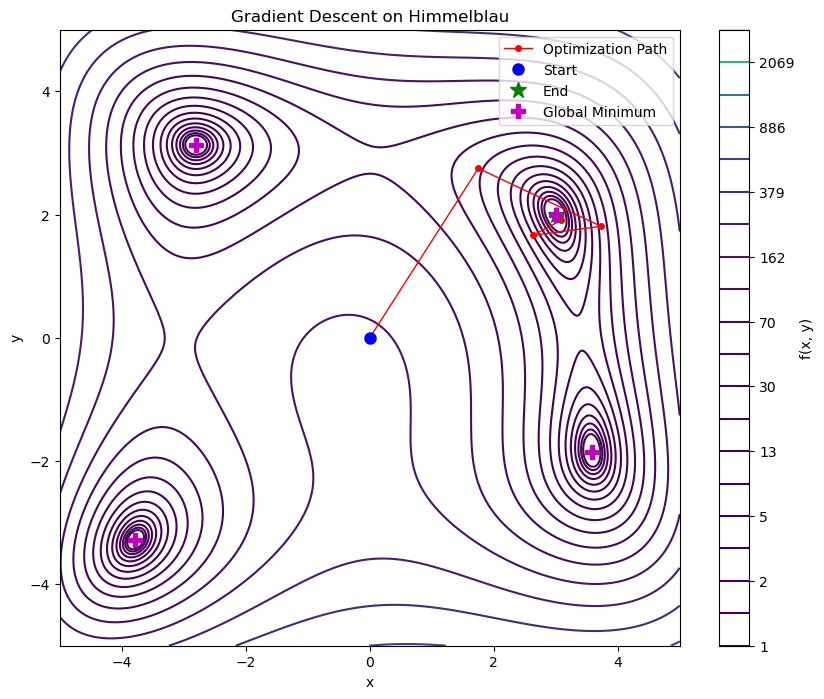

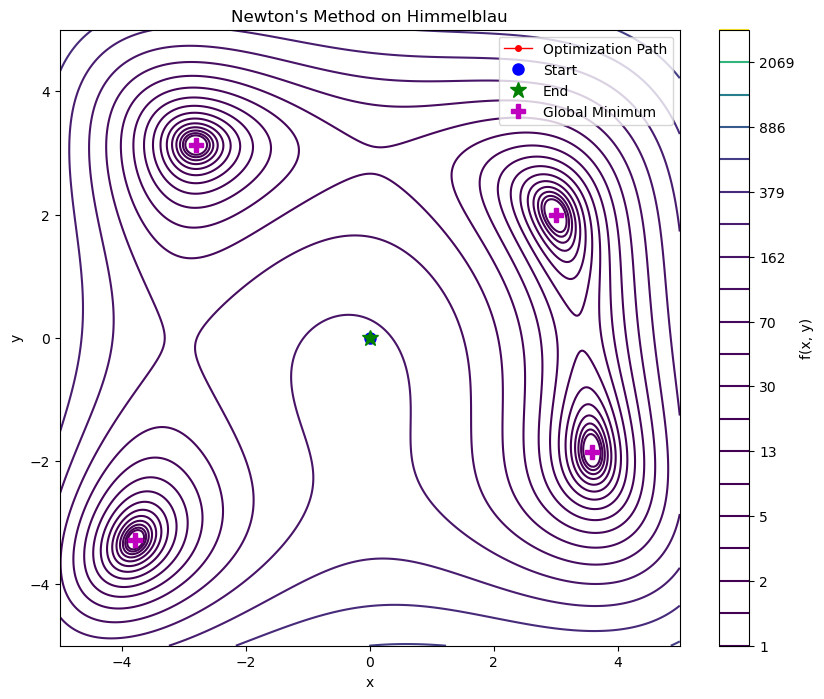

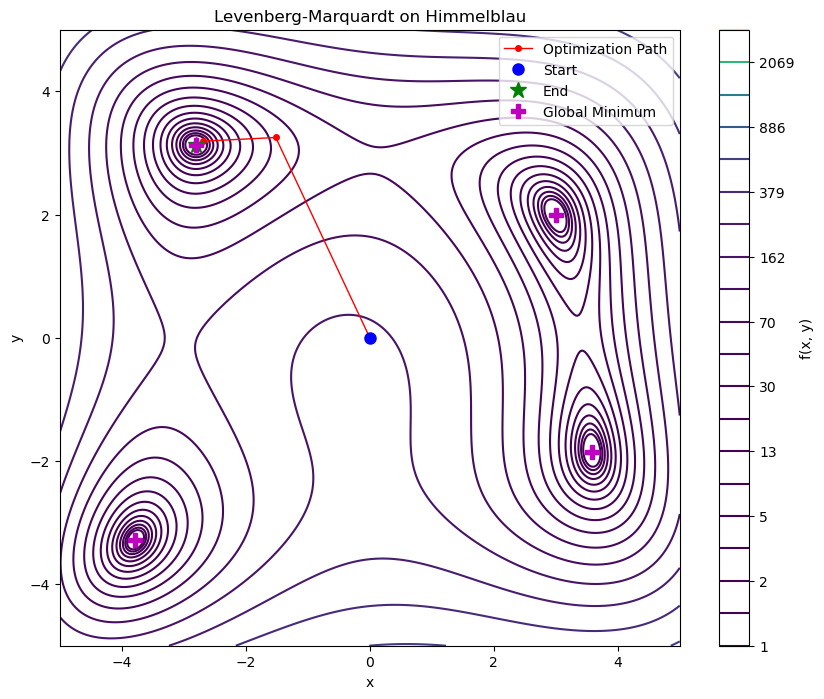

In [14]:
# Plotting for Himmelblau
plot_optimization_path(himmelblau, himmelblau_range, himmelblau_minimum, gd_results_himm['history'], "Gradient Descent on Himmelblau")
plot_optimization_path(himmelblau, himmelblau_range, himmelblau_minimum, nm_results_himm['history'], "Newton's Method on Himmelblau")
plot_optimization_path(himmelblau, himmelblau_range, himmelblau_minimum, lm_results_himm['history'], "Levenberg-Marquardt on Himmelblau")

## **8. Conclusion**

In this notebook, we explored three fundamental methods for unconstrained multivariate optimization.

  * **Gradient Descent** is simple and robust but can be very slow, especially on functions with long, narrow valleys like Rosenbrock's. The use of line search makes it more efficient than a fixed step size.

  * **Newton's Method** is very fast (quadratically convergent) when near a solution. However, it requires computing and inverting the Hessian matrix, which is expensive, and it can fail if the Hessian is not positive definite.

  * **Levenberg-Marquardt** acts as a hybrid method. It successfully navigates the complex landscape of the Rosenbrock function by blending the stability of Gradient Descent with the speed of Newton's method, making it a powerful and widely used algorithm in practice.

The choice of algorithm for a real-world civil engineering problem depends on the specific characteristics of the objective function, the computational resources available, and the required precision of the solution.